# Imports

In [1]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, Normalizer, QuantileTransformer

In [2]:
# Carregando as configurações do arquivo 'config_modelo.json'
configs = json.load(open('config_modelo.json', 'r'))

In [3]:
# Criar a pasta 'save_dir' caso não exista no diretório
if not os.path.exists(configs['model']['save_dir']):
            os.makedirs(configs['model']['save_dir'])

In [4]:
# Carregar o Dataset
filepath = 'C:/Users/auW10/Documents/CodigosDoAu/000_Doutorado/dataset/'
df = pd.read_pickle(filepath+'dataset_ciclo1_multiclass_aug_dim_135_TIs_TargetPerc.pkl')
print(df.shape)
df.head(2)

(139881, 135)


,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,BBANDS_Upper_5,BBANDS_Lower_5,...,ATR_20,TRANGE,MES,DIA_SEMANA,HORA_NOBRE,TARGET_WIN,TARGET_WIN_CAT3,TARGET_WIN_CAT3_LABEL,PRICE_PERCENTAGE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53560.0,53565.0,53405.0,53410.0,8363.0,53752.526189,53227.473811,...,122.7500,160.0,11,2,2,15.0,HOLD,1,106.82,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53410.0,53500.0,53295.0,53415.0,7034.0,53712.281525,53317.718475,...,126.8625,205.0,11,2,2,50.0,HOLD,1,106.83,HOLD


## Split dos Dados

In [5]:
df.columns.tolist()
df.columns.array

<PandasArray>
[             'DATETIME',                  'DATE',                  'TIME',
                  'OPEN',                  'HIGH',                   'LOW',
                 'CLOSE',                   'VOL',        'BBANDS_Upper_5',
        'BBANDS_Lower_5',
 ...
                'ATR_20',                'TRANGE',                   'MES',
            'DIA_SEMANA',            'HORA_NOBRE',            'TARGET_WIN',
       'TARGET_WIN_CAT3', 'TARGET_WIN_CAT3_LABEL',      'PRICE_PERCENTAGE',
     'TARGET_PERCENTAGE']
Length: 135, dtype: object

In [6]:
print(df.shape)
df2 = df.drop([  'OPEN',                  
                 'HIGH',                   
                 'LOW',
                 'CLOSE',                   
                 'VOL',
                 'MES',
                 'TARGET_WIN',
                 'TARGET_WIN_CAT3', 
                 'TARGET_WIN_CAT3_LABEL',      
                 'PRICE_PERCENTAGE'
               
            
              ], axis=1)
print(df2.shape)
df2.head(2)

(139881, 135)
(139881, 125)


,DATETIME,DATE,TIME,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
0,2014-11-19 12:30:00,2014.11.19,12:30:00,53752.526189,53227.473811,53701.563032,53003.436968,53582.216054,52961.783946,53513.521581,...,224.882410,16995.0,183.08836,157.567344,133.163314,122.7500,160.0,2,2,HOLD
1,2014-11-19 12:35:00,2014.11.19,12:35:00,53712.281525,53317.718475,53699.874976,53060.125024,53596.604149,52972.395851,53498.711770,...,-968.557883,24029.0,190.39224,165.472787,139.149704,126.8625,205.0,2,2,HOLD


In [7]:
df3 = df2[df2['DATETIME'].dt.year < 2020]
df3.drop(['DATE', 'TIME'], axis=1, inplace=True)
df4 = df3[df3['DATETIME'].dt.year > 2014].reset_index(drop=True)
#df4

C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [160]:
df_train = df2[(df2['DATETIME'] >= '2015-01-01') & (df2['DATETIME'] < '2018-01-01')]
#df_train = df2[(df2['DATETIME'] >= '2017-12-01') & (df2['DATETIME'] < '2019-07-01')]
#df_train = df_train.iloc[-10000:, :]

#df_train = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2019-09-01')]

#----------------------------------------------------------------------------------------------------

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2019-01-01')]
#df_valid = df2[(df2['DATETIME'] >= '2019-07-01') & (df2['DATETIME'] < '2020-03-01')]
#df_valid = df_valid.iloc[:6600, :]

#df_valid = df2[(df2['DATETIME'] >= '2019-09-01') & (df2['DATETIME'] < '2020-01-01')]

df_valid = df2[(df2['DATETIME'] >= '2018-01-01') & (df2['DATETIME'] < '2020-01-01')]

#----------------------------------------------------------------------------------------------------

df_test  = df2[(df2['DATETIME'] >= '2019-01-01') & (df2['DATETIME'] < '2020-01-01')]
#df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#df_test  = df2[(df2['DATETIME'] < '2017-12-01')]
#df_test = df_test.iloc[:500,:]

df_test  = df2[(df2['DATETIME'] >= '2020-01-01')]

#----------------------------------------------------------------------------------------------------

print('Proporção Train: {:.1%} | Validation: {:.1%} | Test: {:.1%}'.format(
                                            df_train['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_valid['DATETIME'].count()/df2['DATETIME'].count(),
                                            df_test['DATETIME'].count()/df2['DATETIME'].count()))

df_train.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_valid.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
df_test.drop(['DATETIME', 'DATE', 'TIME'], axis=1, inplace=True)
print(df_train.shape, df_valid.shape, df_test.shape)

Proporção Train: 57.0% | Validation: 38.0% | Test: 2.9%
(79795, 122) (53148, 122) (4064, 122)


C:\Users\auW10\Anaconda3\envs\phd\lib\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [161]:
df_test.iloc[19:200].head(1)

,BBANDS_Upper_5,BBANDS_Lower_5,BBANDS_Upper_10,BBANDS_Lower_10,BBANDS_Upper_20,BBANDS_Lower_20,DEMA_20,EMA_5_CLOSE,EMA_10_CLOSE,EMA_20_CLOSE,...,ADOSC,OBV,ATR_3,ATR_6,ATR_12,ATR_20,TRANGE,DIA_SEMANA,HORA_NOBRE,TARGET_PERCENTAGE
135836,117489.521929,116862.478071,117397.405807,116813.594193,117349.698893,116850.801107,117269.240037,117228.122937,117137.461639,117010.529854,...,95344.558922,-7850190.0,212.171216,205.912372,197.823329,186.913789,165.0,3,1,HOLD


In [162]:
df_train['TARGET_PERCENTAGE'].value_counts()

HOLD    57590
BUY     11165
SELL    11040
Name: TARGET_PERCENTAGE, dtype: int64

In [163]:
df_train['TARGET_PERCENTAGE'].value_counts()[0]

57590

In [164]:
hold_train = df_train['TARGET_PERCENTAGE'].value_counts()[0]
hold_valid = df_valid['TARGET_PERCENTAGE'].value_counts()[0]
hold_test = df_test['TARGET_PERCENTAGE'].value_counts()[0]

print('\nDados Categóricos de Treino -- BUY: %d | SELL: %d | HOLD: %d' % (df_train['TARGET_PERCENTAGE'].value_counts()[1], df_train['TARGET_PERCENTAGE'].value_counts()[2], hold_train))
print('\nDados Categóricos de Validação -- BUY: %d | SELL: %d | HOLD: %d' % (df_valid['TARGET_PERCENTAGE'].value_counts()[1], df_valid['TARGET_PERCENTAGE'].value_counts()[2], hold_valid))
print('\nDados Categóricos de Teste -- BUY: %d | SELL: %d | HOLD: %d' % (df_test['TARGET_PERCENTAGE'].value_counts()[1], df_test['TARGET_PERCENTAGE'].value_counts()[2], hold_test))



Dados Categóricos de Treino -- BUY: 11165 | SELL: 11040 | HOLD: 57590

Dados Categóricos de Validação -- BUY: 6367 | SELL: 6232 | HOLD: 40549

Dados Categóricos de Teste -- BUY: 380 | SELL: 355 | HOLD: 3329


In [165]:
df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()

HORA_NOBRE  TARGET_PERCENTAGE
0           HOLD                  3343
            BUY                    575
            SELL                   510
1           HOLD                 14467
            SELL                  3870
            BUY                   3802
2           HOLD                 27011
            BUY                   4272
            SELL                  4245
3           HOLD                 12769
            BUY                   2516
            SELL                  2415
Name: TARGET_PERCENTAGE, dtype: int64

In [166]:
buy_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_train = df_train.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_valid = df_valid.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

buy_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[4]
sell_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[5]
hold_test = df_test.groupby(['HORA_NOBRE'])['TARGET_PERCENTAGE'].value_counts()[3]

print('\nDados Categóricos de Treino Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_train, sell_train, hold_train))
print('\nDados Categóricos de Validação Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_valid, sell_valid, hold_valid))
print('\nDados Categóricos de Teste Hora Nobre -- BUY: %d | SELL: %d | HOLD: %d' % (buy_test, sell_test, hold_test))



Dados Categóricos de Treino Hora Nobre -- BUY: 3870 | SELL: 3802 | HOLD: 14467

Dados Categóricos de Validação Hora Nobre -- BUY: 2263 | SELL: 2245 | HOLD: 10222

Dados Categóricos de Teste Hora Nobre -- BUY: 146 | SELL: 129 | HOLD: 835


In [167]:
np.random.seed(2345)
porcentagem_selecao_train = (buy_train / hold_train)
amostra_train = np.random.choice( a=[0,1], size=hold_train, replace=True, 
                                   p=[1-porcentagem_selecao_train, porcentagem_selecao_train] )
print(len(amostra_train))
print(len(amostra_train[amostra_train == 1]))
print(len(amostra_train[amostra_train == 0]))

14467
3831
10636


In [168]:
np.random.seed(2345)
porcentagem_selecao_valid = (buy_valid / hold_valid)
amostra_valid = np.random.choice( a=[0,1], size=hold_valid, replace=True, 
                                   p=[1-porcentagem_selecao_valid, porcentagem_selecao_valid] )
print(len(amostra_valid))
print(len(amostra_valid[amostra_valid == 1]))
print(len(amostra_valid[amostra_valid == 0]))

10222
2222
8000


In [169]:
np.random.seed(2345)
porcentagem_selecao_test = (buy_test / hold_test)
amostra_test = np.random.choice( a=[0,1], size=hold_test, replace=True, 
                                   p=[1-porcentagem_selecao_test, porcentagem_selecao_test] )
print(len(amostra_test))
print(len(amostra_test[amostra_test == 1]))
print(len(amostra_test[amostra_test == 0]))

835
143
692


In [170]:
def normalize(data):

    scaler_x = StandardScaler()

    x = data.iloc[:, :-2]
    x = scaler_x.fit_transform(x) 

    y = data.iloc[:,-1]
    y_list = np.array(y.to_list())

    return x, y_list

In [171]:
def get_train_valid_test_data(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'][i+seq_len-1] == 'HOLD':
            if amostragem[a] == 0:
                df.drop((i+seq_len-1), axis=0, inplace=True) 
            a+=1

    x, y = normalize(df)

    return x, y

In [172]:
def next_window(i, seq_len, df):
    df = df[i:i+seq_len]
    scaler_x = StandardScaler()
    
    x = df.iloc[:, :-2]
    # xxx = np.array(x)
    x = scaler_x.fit_transform(x) 
    
    y = df.iloc[-1,-1]
    # y_list = np.array(y.to_list())
    
    return x, y

In [173]:
def get_train_valid_test_data_Slide_Window(seq_len, df, amostragem):
    print('df.shape: ', df.shape)
    a=0
    data_x = []
    data_y = []
    for i in range(len(df) - seq_len):
        if df['TARGET_PERCENTAGE'].iloc[i+seq_len-1] == 'HOLD':
            if amostragem[a] == 1:    
                x, y = next_window(i, seq_len, df)
                data_x.append(x)
                data_y.append(y)
            a+=1
        else:
            x, y = next_window(i, seq_len, df)
            data_x.append(x)
            data_y.append(y)

    return np.array(data_x), np.array(data_y)

In [174]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train, y_train = get_train_valid_test_data(seq_len=1, 
                                             df=df_train_reset_index, 
                                             amostragem=amostra_train)
print('x_train: ', x_train.shape,' | y_train: ', y_train.shape)

df.shape:  (22139, 122)
x_train:  (11503, 120)  | y_train:  (11503,)


In [175]:
df_train_reset_index = df_train[df_train['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_train_sw, y_train_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_train_reset_index, 
                                                                 amostragem=amostra_train)
print('x_train_sw: ', x_train_sw.shape,' | y_train_sw: ', y_train_sw.shape)

df.shape:  (22139, 122)
x_train_sw:  (11495, 20, 120)  | y_train_sw:  (11495,)


In [176]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid, y_valid = get_train_valid_test_data( seq_len=1, 
                                              df=df_valid_reset_index, 
                                              amostragem=amostra_valid )
print(x_valid.shape, y_valid.shape)

df.shape:  (14730, 122)
(6730, 120) (6730,)


In [177]:
df_valid_reset_index = df_valid[df_valid['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_valid_sw, y_valid_sw = get_train_valid_test_data_Slide_Window( seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_valid_reset_index, 
                                                                 amostragem=amostra_valid )
print(x_valid_sw.shape, y_valid_sw.shape)

df.shape:  (14730, 122)
(6724, 20, 120) (6724,)


In [178]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test, y_test = get_train_valid_test_data( seq_len=1, 
                                            df=df_test_reset_index, 
                                            amostragem=amostra_test )
print(x_test.shape, y_test.shape)

df.shape:  (1110, 122)
(419, 120) (419,)


In [179]:
df_test_reset_index = df_test[df_test['HORA_NOBRE'] == '1'].reset_index(drop=True)
x_test_sw, y_test_sw = get_train_valid_test_data_Slide_Window(   seq_len=configs['dataset']['sequence_length'], 
                                                                 df=df_test_reset_index, 
                                                                 amostragem=amostra_test)
print(x_test_sw.shape, y_test_sw.shape)

df.shape:  (1110, 122)
(411, 20, 120) (411,)


In [180]:
def contagem_classes(data, name):
    cont_buy = 0
    cont_sell = 0
    cont_hold = 0
    for n in data:
        if ((n == 'BUY') or (n == 0)):
            cont_buy+=1
        if ((n == 'HOLD') or (n == 1)):
            cont_hold+=1
        if ((n == 'SELL') or (n == 2)):
            cont_sell+=1
    print('{}.size: '.format(name), data.size, ' | cont_buy: ', cont_buy, ' | cont_hold: ', cont_hold, ' | cont_sell: ', cont_sell)

In [181]:
print('Contagem de Classes\n')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_train, 'y_train   ')
contagem_classes(y_train_sw, 'y_train_sw')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_valid, 'y_valid   ')
contagem_classes(y_valid_sw, 'y_valid_sw')
print('-----------------------------------------------------------------------------------')
contagem_classes(y_test, 'y_test   ')
contagem_classes(y_test_sw, 'y_test_sw')
print('-----------------------------------------------------------------------------------')

Contagem de Classes

-----------------------------------------------------------------------------------
y_train   .size:  11503  | cont_buy:  3802  | cont_hold:  3831  | cont_sell:  3870
y_train_sw.size:  11495  | cont_buy:  3799  | cont_hold:  3827  | cont_sell:  3869
-----------------------------------------------------------------------------------
y_valid   .size:  6730  | cont_buy:  2245  | cont_hold:  2222  | cont_sell:  2263
y_valid_sw.size:  6724  | cont_buy:  2242  | cont_hold:  2220  | cont_sell:  2262
-----------------------------------------------------------------------------------
y_test   .size:  419  | cont_buy:  129  | cont_hold:  144  | cont_sell:  146
y_test_sw.size:  411  | cont_buy:  125  | cont_hold:  140  | cont_sell:  146
-----------------------------------------------------------------------------------


## Cálculo do Weighted F Score

In [182]:
def weightedFScore(confusion_matrix):
    beta_1 = math.pow(0.5, 2)
    beta_2 = math.pow(0.25, 2)
    beta_3 = math.pow(0.125, 2)
    
    num_tu = confusion_matrix[[0],[0]]
    num_tf = confusion_matrix[[1],[1]]
    num_td = confusion_matrix[[2],[2]]
    
    wrongF_trueU = confusion_matrix[[0],[1]]
    wrongD_trueU = confusion_matrix[[0],[2]]
    
    wrongU_trueF = confusion_matrix[[1],[0]]
    wrongD_trueF = confusion_matrix[[1],[2]]
  
    wrongU_trueD = confusion_matrix[[2],[0]]
    wrongF_trueD = confusion_matrix[[2],[1]]
    
    num_tp = num_tu + num_td + (beta_3 * num_tf)
    erro_tipo_1 = wrongU_trueD + wrongD_trueU
    erro_tipo_2 = wrongU_trueF + wrongD_trueF
    erro_tipo_3 = wrongF_trueU + wrongF_trueD
    
    num = (1 + beta_1 + beta_2) * num_tp
    den = num + erro_tipo_1 + (beta_1 * erro_tipo_2) + (beta_2 * erro_tipo_3)
    
    wFScore = num / den
    
    return wFScore

# Modelos

In [31]:
import lightgbm as lgbm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## LightGBM

In [32]:
model_lgbm = lgbm.LGBMClassifier(n_jobs=-1, random_state=0, n_estimators=5000, learning_rate=0.001, num_leaves=2**6,
                                 subsample=0.9, subsample_freq=1, colsample_bytree=1.)

model_lgbm.fit(x_train, y_train)
predict_lgbm = model_lgbm.predict(x_test)

accuracy_score_LGBM = accuracy_score(y_test, predict_lgbm)

print('Accuracy Score - LightGBM: ', accuracy_score_LGBM)

Accuracy Score - LightGBM:  0.360381861575179


In [33]:
print(classification_report(y_test, predict_lgbm))

              precision    recall  f1-score   support

         BUY       0.31      0.34      0.32       129
        HOLD       0.40      0.37      0.39       144
        SELL       0.37      0.37      0.37       146

    accuracy                           0.36       419
   macro avg       0.36      0.36      0.36       419
weighted avg       0.36      0.36      0.36       419



In [34]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_lgbm, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[44, 38, 47],
       [47, 53, 44],
       [52, 40, 54]], dtype=int64)

In [35]:
print('Contagem de Classes -> predict_lgbm\n')
contagem_classes(predict_lgbm, 'predict_lgbm')

Contagem de Classes -> predict_lgbm

predict_lgbm.size:  419  | cont_buy:  143  | cont_hold:  131  | cont_sell:  145


<AxesSubplot:>

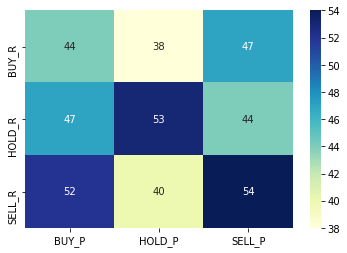

In [36]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LGBM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

In [37]:
weightedFScore_LGBM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LGBM

0.5060212046981016

### Compare train and test set accuracy

In [ ]:
#y_pred_train = model_lgbm.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [ ]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_lgbm.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_lgbm.score(x_test, y_test)))

In [ ]:
#print('Validation set score: {:.4f}'.format(model_lgbm.score(x_valid, y_valid)))

## Random Forest

In [38]:
model_randomF = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators=5000)
model_randomF.fit(x_train, y_train)
predict_randomF = model_randomF.predict(x_test)

accuracy_score_RF = accuracy_score(y_test, predict_randomF)
print('Accuracy Score - Random Forest: ', accuracy_score_RF)

Accuracy Score - Random Forest:  0.3412887828162291


In [39]:
print(classification_report(y_test, predict_randomF))

              precision    recall  f1-score   support

         BUY       0.29      0.32      0.31       129
        HOLD       0.35      0.35      0.35       144
        SELL       0.38      0.35      0.36       146

    accuracy                           0.34       419
   macro avg       0.34      0.34      0.34       419
weighted avg       0.34      0.34      0.34       419



In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predict_randomF, labels=["BUY", "HOLD", "SELL"])
confusion_matrix

array([[41, 45, 43],
       [51, 51, 42],
       [47, 48, 51]], dtype=int64)

In [41]:
print('Contagem de Classes -> predict_randomF\n')
contagem_classes(predict_randomF, 'predict_randomF')

Contagem de Classes -> predict_randomF

predict_randomF.size:  419  | cont_buy:  139  | cont_hold:  144  | cont_sell:  136


<AxesSubplot:>

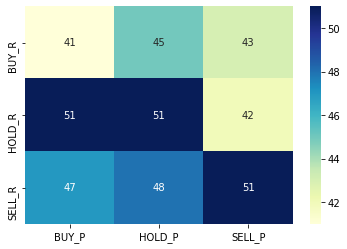

In [42]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_RF = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

In [43]:
weightedFScore_RF = weightedFScore(confusion_matrix)[0] 
weightedFScore_RF

0.5056742850887329

### Compare train and test set accuracy

In [ ]:
#y_pred_train = model_randomF.predict(x_train)
#print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

### Check for Overfitting

In [ ]:
# print the scores on training and test set

#print('Training set score: {:.4f}'.format(model_randomF.score(x_train, y_train)))

#print('Test set score: {:.4f}'.format(model_randomF.score(x_test, y_test)))

In [ ]:
#print('Validation set score: {:.4f}'.format(model_randomF.score(x_valid, y_valid)))

# Deep Learning

In [216]:
# Encoding categorical data
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def encode_categ_data(data):
    labelencoder = LabelEncoder()
    x = labelencoder.fit_transform(data)
    data_encoded = to_categorical(x)
    
    #print(data[10:20])
    #print(data_encoded[10:20])
    
    return data_encoded

In [217]:
# example of training a final classification model
from keras.models import Sequential, load_model
from core.utils import Timer
from keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
dim = x_train.shape[1]

## DNN

In [215]:
# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(75, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.5))
model_dnn.add(Dense(25, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:00.979085


In [86]:
'''# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(100, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(50, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(30, activation='relu'))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(15, activation='relu'))
model_dnn.add(Dropout(0.2))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()
'''

"# define and fit the final model\ntimer = Timer()\ntimer.start()\n\nmodel_dnn = Sequential()\n\nmodel_dnn.add(Dense(100, input_dim=dim, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(50, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(30, activation='relu'))\nmodel_dnn.add(Dropout(0.3))\nmodel_dnn.add(Dense(15, activation='relu'))\nmodel_dnn.add(Dropout(0.2))\nmodel_dnn.add(Dense(3, activation='softmax'))\n\nmodel_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])\n\nprint('[model] Model Compiled')\n#print(model_dnn.summary())\ntimer.stop()\n"

In [218]:
### SIMPLÃO ###

# define and fit the final model
timer = Timer()
timer.start()

model_dnn = Sequential()

model_dnn.add(Dense(30, input_dim=dim, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(15, activation='relu'))
model_dnn.add(Dropout(0.4))
model_dnn.add(Dense(3, activation='softmax'))

model_dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_dnn.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:00.301294


In [219]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_DNN.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]
es_callbacks = [ EarlyStopping(monitor='val_loss', patience=3) ]

y_train_enc = encode_categ_data(y_train)
y_valid_enc = encode_categ_data(y_valid)
H = model_dnn.fit( x_train, y_train_enc, validation_data=(x_valid, y_valid_enc), epochs=50, 
                   callbacks=callbacks, workers=1 )

model_dnn.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
Train on 11503 samples, validate on 6730 samples
Epoch 1/50
11503/11503 [==============================] - 4s 363us/step - loss: 1.1537 - accuracy: 0.3561 - val_loss: 1.0863 - val_accuracy: 0.3954
Epoch 2/50
11503/11503 [==============================] - 5s 399us/step - loss: 1.0958 - accuracy: 0.3749 - val_loss: 1.0821 - val_accuracy: 0.3780
Epoch 3/50
11503/11503 [==============================] - 6s 506us/step - loss: 1.0828 - accuracy: 0.3886 - val_loss: 1.0777 - val_accuracy: 0.3902
Epoch 4/50
11503/11503 [==============================] - 5s 414us/step - loss: 1.0826 - accuracy: 0.3834 - val_loss: 1.0766 - val_accuracy: 0.3903
Epoch 5/50
11503/11503 [==============================] - 4s 362us/step - loss: 1.0769 - accuracy: 0.3971 - val_loss: 1.0749 - val_accuracy: 0.4013
Epoch 6/50
11503/11503 [==============================] - 5s 410us/step - loss: 1.0758 - accuracy: 0.4010 - val_loss: 1.0728 - val_accuracy: 0.4080
Epoch 7/50
11503/11503 [==============

In [220]:
# new instances where we do not know the answer
y_pred = model_dnn.predict(x_test) 
y_pred

array([[0.21926968, 0.5326629 , 0.24806742],
       [0.37110284, 0.23554148, 0.39335573],
       [0.3790373 , 0.22086546, 0.40009725],
       ...,
       [0.35590857, 0.28705418, 0.35703728],
       [0.3901944 , 0.25753924, 0.35226637],
       [0.43849617, 0.20471887, 0.356785  ]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


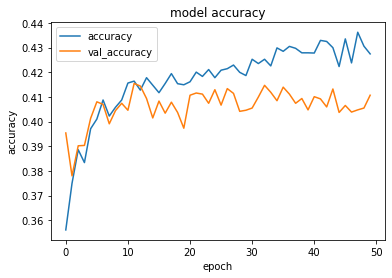

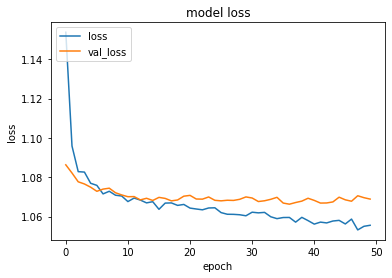

In [221]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [222]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_enc = encode_categ_data(y_test)
for i in y_test_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

In [223]:
print(y_pred[10:20])
print(y_test_enc[10:20])

[[0.31999046 0.34912983 0.3308798 ]
 [0.3330083  0.38709024 0.27990144]
 [0.32793635 0.32938662 0.34267703]
 [0.31720486 0.3684899  0.31430525]
 [0.31220865 0.3551595  0.3326319 ]
 [0.34132847 0.312547   0.3461245 ]
 [0.3771952  0.27015078 0.35265404]
 [0.44743901 0.19618683 0.35637414]
 [0.37422976 0.24078423 0.38498604]
 [0.35166034 0.25698492 0.39135474]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [224]:
print(pred_array[10:20])
print(real_array[10:20])

[1 1 2 1 1 2 0 0 2 2]
[0 1 1 1 1 1 0 0 0 1]


In [225]:
accuracy_score_DNN = accuracy_score(real_array, pred_array)
print('Accuracy Score - DL: ', accuracy_score_DNN)

Accuracy Score - DL:  0.3556085918854415


In [226]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.30      0.28      0.29       129
           1       0.38      0.41      0.40       144
           2       0.37      0.37      0.37       146

    accuracy                           0.36       419
   macro avg       0.35      0.35      0.35       419
weighted avg       0.35      0.36      0.35       419



In [227]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[36, 45, 48],
       [42, 59, 43],
       [42, 50, 54]], dtype=int64)

In [228]:
print('Contagem de Classes -> DNN_real_array\n')
contagem_classes(real_array, 'DNN_real_array')

Contagem de Classes -> DNN_real_array

DNN_real_array.size:  419  | cont_buy:  129  | cont_hold:  144  | cont_sell:  146


In [229]:
print('Contagem de Classes -> DNN_pred_array\n')
contagem_classes(pred_array, 'DNN_pred_array')

Contagem de Classes -> DNN_pred_array

DNN_pred_array.size:  419  | cont_buy:  120  | cont_hold:  154  | cont_sell:  145


<AxesSubplot:>

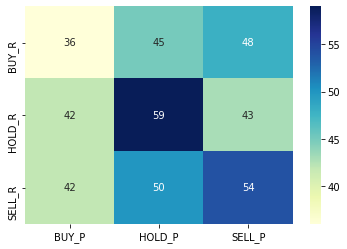

In [230]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_DNN = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

In [231]:
weightedFScore_DNN = weightedFScore(confusion_matrix)[0] 
weightedFScore_DNN

0.5045396554073304

In [232]:
y_pred_train = model_dnn.predict(x_train)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
for i in y_train_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score: 0.4485


# LSTM

In [61]:
# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(200, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(150, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:01.886485


In [ ]:
'''# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(SimpleRNN(150, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(SimpleRNN(125, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(SimpleRNN(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(SimpleRNN(90, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(GRU(80, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(GRU(70, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(LSTM(75, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(GRU(75, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()
'''

In [250]:
### SIMPLÃO ###

# define and fit the final model
timer = Timer()
timer.start()
timesteps = configs['dataset']['sequence_length']

model_lstm = Sequential()

model_lstm.add(LSTM(100, input_shape=(timesteps, dim), return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(50, input_shape=(timesteps, dim), return_sequences=False))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('[model] Model Compiled')
#print(model_lstm.summary())
timer.stop()


[model] Model Compiled
Time taken: 0:00:01.290626


In [251]:
timer = Timer()
timer.start()
print('[Model] Training Started')

save_dir=configs['model']['save_dir']
my_model=configs['model']['model_name']
save_fname = os.path.join(save_dir, '%s_LSTM_activTanh.h5' % my_model)

batch_size=configs['training']['batch_size']

callbacks = [ ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)]

y_train_sw_enc = encode_categ_data(y_train_sw)
y_valid_sw_enc = encode_categ_data(y_valid_sw)
H = model_lstm.fit( x_train_sw, y_train_sw_enc, validation_data=(x_valid_sw, y_valid_sw_enc), epochs=25, 
                    batch_size=batch_size, callbacks=callbacks, workers=1 )

model_lstm.save(save_fname)

print('[Model] Training Completed.')
print('Model saved as %s' % save_fname)

timer.stop()

[Model] Training Started
Train on 11495 samples, validate on 6724 samples
Epoch 1/25
11495/11495 [==============================] - 11s 958us/step - loss: 1.1143 - accuracy: 0.3543 - val_loss: 1.0953 - val_accuracy: 0.3592
Epoch 2/25
11495/11495 [==============================] - 14s 1ms/step - loss: 1.0920 - accuracy: 0.3829 - val_loss: 1.0999 - val_accuracy: 0.3556
Epoch 3/25
11495/11495 [==============================] - 11s 991us/step - loss: 1.0825 - accuracy: 0.3998 - val_loss: 1.1015 - val_accuracy: 0.3528
Epoch 4/25
11495/11495 [==============================] - 10s 857us/step - loss: 1.0690 - accuracy: 0.4307 - val_loss: 1.1099 - val_accuracy: 0.3657
Epoch 5/25
11495/11495 [==============================] - 10s 863us/step - loss: 1.0541 - accuracy: 0.4452 - val_loss: 1.1202 - val_accuracy: 0.3718
Epoch 6/25
11495/11495 [==============================] - 10s 848us/step - loss: 1.0321 - accuracy: 0.4745 - val_loss: 1.1300 - val_accuracy: 0.3709
Epoch 7/25
11495/11495 [==========

In [252]:
# new instances where we do not know the answer
y_pred = model_lstm.predict(x_test_sw) 
y_pred

array([[0.04040393, 0.7284071 , 0.23118891],
       [0.01774833, 0.26820663, 0.7140451 ],
       [0.01641522, 0.13144612, 0.85213864],
       ...,
       [0.03507772, 0.24134886, 0.7235734 ],
       [0.04222221, 0.7893238 , 0.16845408],
       [0.00405183, 0.46864608, 0.5273021 ]], dtype=float32)

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


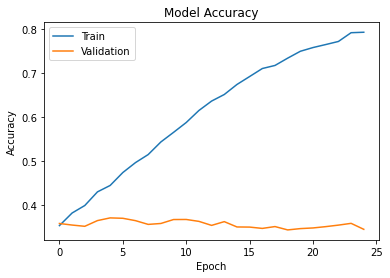

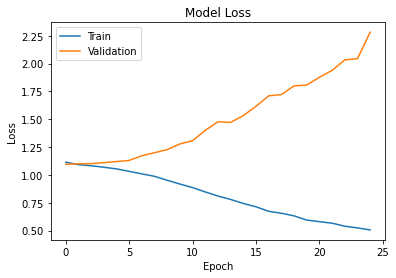

In [253]:
# list all data in history       
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_path = 'accuracy_history.png'
plt.savefig(fig_path)     
plt.show()

# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
fig_path = 'loss_history.png'
plt.savefig(fig_path) 
plt.show()

In [254]:
# BUY | SELL | HOLD

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_test_sw_enc = encode_categ_data(y_test_sw)
for i in y_test_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)   

In [255]:
print(y_pred[0:10])
print(pred_array[0:10])

[[0.04040393 0.7284071  0.23118891]
 [0.01774833 0.26820663 0.7140451 ]
 [0.01641522 0.13144612 0.85213864]
 [0.16011198 0.33031443 0.50957364]
 [0.13801706 0.7841876  0.07779536]
 [0.23122142 0.6777161  0.09106253]
 [0.29320943 0.15240061 0.55438995]
 [0.8855243  0.04529655 0.06917915]
 [0.9799652  0.01704697 0.00298786]
 [0.9762597  0.02099077 0.00274954]]
[1 2 2 2 1 1 2 0 0 0]


In [256]:
print(y_test_sw_enc[100:110])
print(real_array[100:110])

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[2 2 2 1 2 2 1 1 2 2]


In [257]:
accuracy_score_LSTM = accuracy_score(real_array, pred_array)
print('Accuracy Score - LSTM: ', accuracy_score_LSTM)

Accuracy Score - LSTM:  0.35766423357664234


In [258]:
print(classification_report(real_array, pred_array))

              precision    recall  f1-score   support

           0       0.25      0.25      0.25       125
           1       0.45      0.36      0.40       140
           2       0.37      0.45      0.41       146

    accuracy                           0.36       411
   macro avg       0.36      0.35      0.35       411
weighted avg       0.36      0.36      0.36       411



In [259]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(real_array, pred_array)
confusion_matrix

array([[31, 32, 62],
       [42, 51, 47],
       [50, 31, 65]], dtype=int64)

In [260]:
print('Contagem de Classes -> LSTM_real_array\n')
contagem_classes(real_array, 'LSTM_real_array')

Contagem de Classes -> LSTM_real_array

LSTM_real_array.size:  411  | cont_buy:  125  | cont_hold:  140  | cont_sell:  146


In [261]:
print('Contagem de Classes -> LSTM_pred_array\n')
contagem_classes(pred_array, 'LSTM_pred_array')

Contagem de Classes -> LSTM_pred_array

LSTM_pred_array.size:  411  | cont_buy:  123  | cont_hold:  114  | cont_sell:  174


In [262]:
weightedFScore_LSTM = weightedFScore(confusion_matrix)[0] 
weightedFScore_LSTM

0.47899660897131435

<AxesSubplot:>

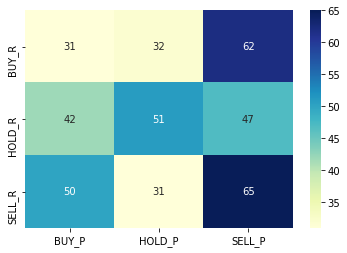

In [263]:
# visualize confusion matrix with seaborn heatmap
cm_matrix_LSTM = pd.DataFrame(data=confusion_matrix,
                        columns=['BUY_P', 'HOLD_P', 'SELL_P'], 
                        index=['BUY_R', 'HOLD_R', 'SELL_R'])

sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

In [264]:
y_pred_train_sw = model_lstm.predict(x_train_sw)

labels = ['BUY', 'HOLD', 'SELL'] 

pred = []
for i in y_pred_train_sw:
    pred.append(np.argmax(i))
pred_array = np.array(pred)       

real = []
y_train_sw_enc = encode_categ_data(y_train_sw)
for i in y_train_sw_enc:
    real.append(np.argmax(i))
real_array = np.array(real)    

print('Training-set accuracy score LSTM: {0:0.4f}'. format(accuracy_score(real_array, pred_array)))

Training-set accuracy score LSTM: 0.8334


# Resumo

In [76]:
print('-------------Resumo-------------')

print('\nAccuracy Score - LGBM: ', accuracy_score_LGBM)
print('Weighted F Score - LGBM: ', weightedFScore_LGBM)

print('\nAccuracy Score - Random Forest: ', accuracy_score_RF)
print('Weighted F Score - Random Forest: ', weightedFScore_RF)

print('\nAccuracy Score - DNN: ', accuracy_score_DNN)
print('Weighted F Score - DNN: ', weightedFScore_DNN)

print('\nAccuracy Score - LSTM: ', accuracy_score_LSTM)
print('Weighted F Score - LSTM: ', weightedFScore_LSTM)

-------------Resumo-------------

Accuracy Score - LGBM:  0.360381861575179
Weighted F Score - LGBM:  0.5060212046981016

Accuracy Score - Random Forest:  0.3412887828162291
Weighted F Score - Random Forest:  0.5056742850887329

Accuracy Score - DNN:  0.3723150357995227
Weighted F Score - DNN:  0.5557260105852574

Accuracy Score - LSTM:  0.3309002433090024
Weighted F Score - LSTM:  0.4795949677815281


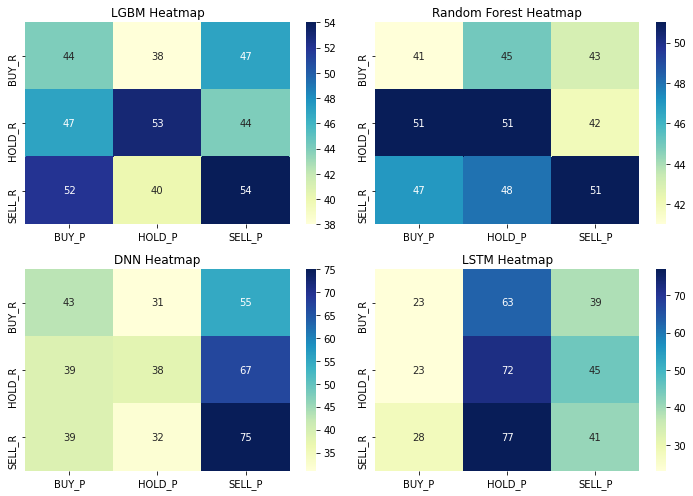

In [77]:
plt.figure(figsize=[10,7])
plt.subplot(2,2,1)
plt.title('LGBM Heatmap')
sns.heatmap(cm_matrix_LGBM, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,2)
plt.title('Random Forest Heatmap')
sns.heatmap(cm_matrix_RF, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,3)
plt.title('DNN Heatmap')
sns.heatmap(cm_matrix_DNN, annot=True, fmt='d', cmap='YlGnBu')

plt.subplot(2,2,4)
plt.title('LSTM Heatmap')
sns.heatmap(cm_matrix_LSTM, annot=True, fmt='d', cmap='YlGnBu')

plt.tight_layout()

In [78]:
# save trained model
#pickle.dump( model_lgbm, open( 'saved_models/model_LGBM_135features_5000.pkl', 'wb' ) )

In [79]:
#pickle.dump( model_dnn, open( 'saved_models/model_DNN_135features_50.pkl', 'wb' ) )

In [80]:
#pickle.dump( model_randomF, open( 'saved_models/model_RF_135features_5000.pkl', 'wb' ) )